In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import importlib as imp

import src
import trecs
from trecs.models import ContentFiltering
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement

random_state = np.random.seed(42)

In [50]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

## Analyzing Communities in MovieLens

In [3]:
ratings_df = pd.read_csv('data/ml-100k/u.data', 
                 sep="\t", 
                 names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

In [4]:
# Add 1000 to every MovieID so they don't overlap with UserID
ratings_df['MovieID'] = ratings_df['MovieID'] + 1000

In [5]:
ratings_df.sort_values('UserID').head(5)

,UserID,MovieID,Rating,Timestamp
66567,1,1055,5,875072688
62820,1,1203,4,878542231
10207,1,1183,5,875072262
9971,1,1150,5,876892196
22496,1,1068,4,875072688


In [6]:
graph_dct = ratings_df.groupby('UserID')['MovieID'].apply(list).to_dict()

G = nx.MultiGraph(graph_dct)
print(nx.info(G))

# # visualize graph
# color_map = []
# for node in G:
#     if node < 1000:
#         color_map.append('blue')
#     else: 
#         color_map.append('green')      


# pos = nx.spring_layout(G)
# nx.draw(G, node_color=color_map, node_size=15, alpha=0.8)
# plt.show()

MultiGraph with 2625 nodes and 100000 edges


In [7]:
from community import community_louvain

comms = community_louvain.best_partition(G, resolution=2.5)

unique_coms = np.unique(list(comms.values()))
unique_coms

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])

In [8]:
# cmap = {
#     0 : 'maroon',
#     1 : 'teal',
#     2 : 'black', 
#     3 : 'orange',
#     4 : 'green',
#     5 : 'yellow'
# }

# node_cmap = [cmap[v] for _,v in comms.items()]

# pos = nx.spring_layout(G)
# nx.draw(G, pos, node_size = 10, alpha = 0.8, node_color=node_cmap)
# plt.show()

In [9]:
# Add comms to ratings_df as column communtyID
for i in range(len(ratings_df)):
    ratings_df.loc[i, 'communityID'] = comms[ratings_df.loc[i, 'UserID']]

In [10]:
ratings_df.head(5)

,UserID,MovieID,Rating,Timestamp,communityID
0,196,1242,3,881250949,1.0
1,186,1302,3,891717742,31.0
2,22,1377,1,878887116,13.0
3,244,1051,2,880606923,55.0
4,166,1346,1,886397596,2.0


Text(0, 0.5, 'Number of Movies')

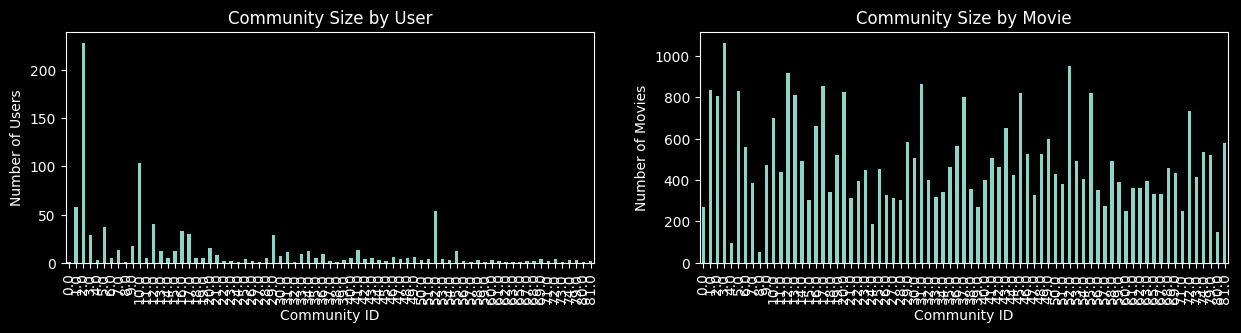

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
ratings_df.groupby('communityID')['UserID'].nunique().plot(kind='bar', ax=ax[0])
ratings_df.groupby('communityID')['MovieID'].nunique().plot(kind='bar', ax=ax[1])

ax[0].set_title('Community Size by User')
ax[0].set_xlabel('Community ID')
ax[0].set_ylabel('Number of Users')
ax[1].set_title('Community Size by Movie')
ax[1].set_xlabel('Community ID')
ax[1].set_ylabel('Number of Movies')

Text(0.5, 1.0, 'Number of reached Communities')

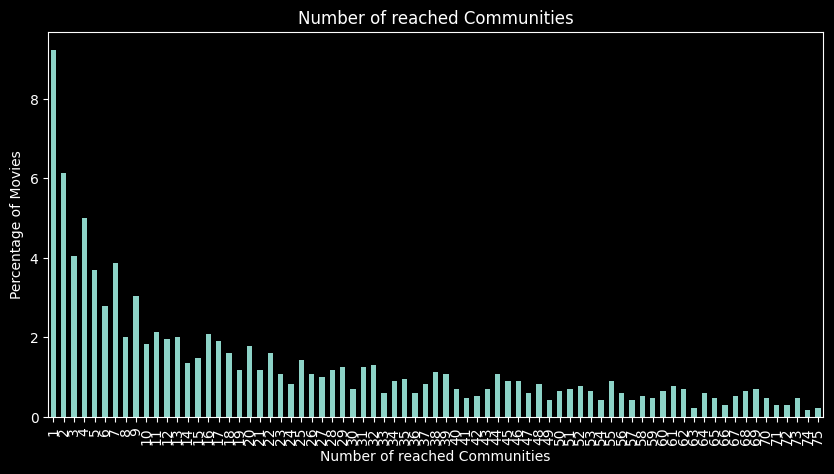

In [12]:
num_movies = len(np.unique(ratings_df['MovieID']))
temp = ratings_df.groupby('MovieID')['communityID'].nunique().sort_values(ascending=True)
#group temp by value
temp = temp.groupby(temp.values).count()
#divide values of temp by num_movies
temp = temp/num_movies * 100
#create bar chart of temp in descending order
temp.plot(kind='bar', figsize=(10, 5))
# add axes
plt.xlabel('Number of reached Communities')
plt.ylabel('Percentage of Movies')
plt.title('Number of reached Communities')

In [13]:
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies_df = pd.read_csv('data/ml-100k/u.item', sep="|", names=movie_cols, encoding='latin')

display(movies_df.head(2))
print(movies_df.shape)

,movie_id,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0


(1682, 24)


In [14]:
# join ratings_df and movies_df on movie_id
large_df = ratings_df.merge(movies_df, left_on='MovieID', right_on='movie_id')
large_df = large_df.drop(columns=['movie_id', 'release_date', 'video_release_date', 'Timestamp', 'Rating', 'title', 'IMDb_URL', 'unknown'])

large_df.head(2)
# group by communityID and sum all genre columns
genre_df = large_df.groupby('communityID').sum()
genre_df.head(5)
# for each communityID list the most common genre
# genre_df.drop(columns=['MovieID', 'UserID', 'Drama']).idxmax(axis=1)

,UserID,MovieID,Action,Adventure,Animation,Childrens,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
communityID,,,,,,,,,,,,,,,,,,,,
0.0,272,309128,26,14,6,15,94,22,10,122,3,1,5,8,7,35,7,30,6,3
1.0,1387502,3651341,293,157,14,99,947,167,71,1401,26,36,31,117,80,496,67,361,74,11
2.0,3176548,8379449,382,86,10,138,2223,252,342,3232,96,151,70,223,159,1267,41,374,48,12
3.0,1226379,4783174,323,100,59,184,1106,193,146,1837,29,26,70,88,82,535,65,358,106,32
4.0,60271,127064,8,5,2,3,27,3,5,49,2,2,2,6,1,12,5,10,3,0


<AxesSubplot:xlabel='MovieID'>

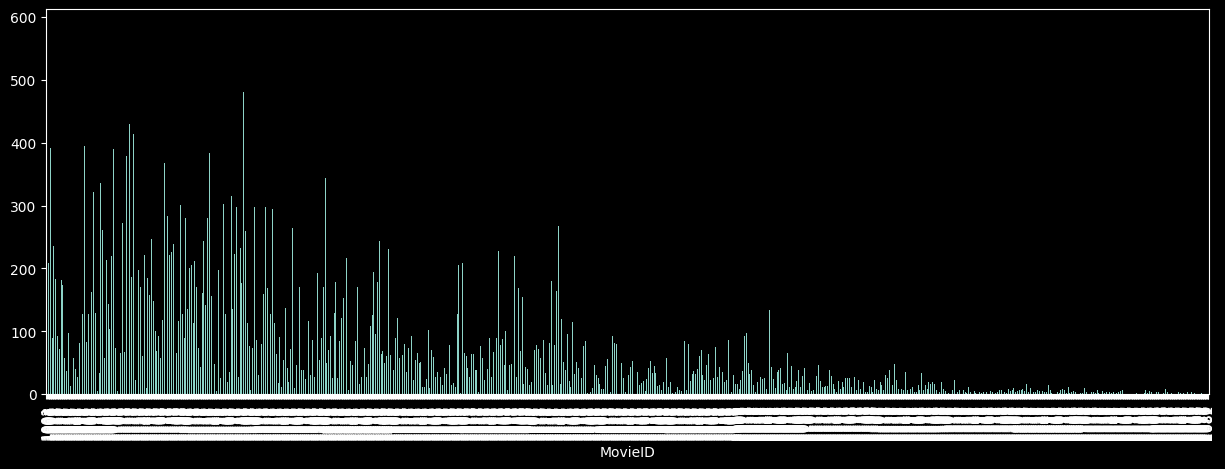

In [15]:
# create graph of number of interactions per movie
ratings_df.groupby('MovieID')['UserID'].count().plot(kind='bar', figsize=(15, 5))

## Creating RecommenderSystem on MovieLens 

### Creating Embeddings

In [16]:
from sklearn.decomposition import NMF

binary_ratings_df = ratings_df.drop(columns=['Timestamp'])
binary_ratings_df.loc[binary_ratings_df['Rating'] > 0, 'Rating'] = 1

# turn dataframe into matrix where each movie is a column and each user is a row
binary_ratings_matrix = binary_ratings_df.pivot(index='UserID', columns='MovieID', values='Rating').fillna(0).to_numpy()

In [17]:
from lightfm.cross_validation import random_train_test_split
from scipy import sparse

# split data into train and test sets
train_interactions, test_interactions = random_train_test_split(sparse.csr_matrix(binary_ratings_matrix), test_percentage=0.2, random_state=random_state)
train_interactions = train_interactions.toarray()
test_interactions = test_interactions.toarray()

c:\Users\Jannik\anaconda3\envs\rsenv\lib\site-packages\lightfm\_lightfm_fast.py:10: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  "LightFM was compiled without OpenMP support. "


In [67]:
n_attrs=100

nmf = NMF(n_components=n_attrs, solver="mu", max_iter=500)
user_representation = nmf.fit_transform(binary_ratings_matrix)
item_representation = nmf.components_
print(user_representation.shape, item_representation.shape)

(943, 100) (100, 1682)


## Create RS Model

In [19]:
recsys = trecs.models.ContentFiltering(
    user_representation=user_representation,
    item_representation=item_representation,
    record_base_state=True,
)

In [21]:
print("Model representation of users and items are given by:")
print(f"- An all-zeros matrix of users of dimension {recsys.predicted_user_profiles.shape}")
print(f"- A randomly generated matrix of items of dimension {recsys.predicted_item_attributes.shape}")

Model representation of users and items are given by:
- An all-zeros matrix of users of dimension (943, 100)
- A randomly generated matrix of items of dimension (100, 1682)


In [23]:
user_pairs = [(u_idx, v_idx) for u_idx in range(recsys.num_users) for v_idx in range(recsys.num_users)]

mse = MSEMeasurement(diagnostics=True)

recsys.add_metrics(InteractionMeasurement(),
                   mse,
                   InteractionSpread(),
                   RecSimilarity(pairs=user_pairs),
                   )

### Calculate MSE

In [33]:
# Calculate the mean absolute error using the recsys score function and a threshold value to decide when to recommend
from sklearn.metrics import mean_squared_error

prediction_threshold = 0.6

predicted_scores = recsys.score_fn(user_representation, item_representation)
predicted_recs = np.where(predicted_scores > prediction_threshold, 1, 0)

mse = mean_squared_error(binary_ratings_matrix, predicted_recs)

print(f'Mean squared error: {mse}.')

Mean squared error: 0.05095875107021762.


### Create Topic Clusters

In [62]:
from sklearn.cluster import KMeans

def get_topic_clusters(interaction_matrix, n_clusters:int=100, n_attrs:int=100, nmf_solver:str="mu"):
    """
    Creates clusters of movies based on their genre.
    Inputs:
        binary_ratings_matrix: a binary matrix of users and movies
        n_attrs: number of attributes to use in NMF
        nmf_solver: solver to use in NMF
    Outputs:
        clusters: a list of cluster assignments
    """
    # Create topic clusters
    #create co-occurence matrix from binary_interaction_matrix
    co_occurence_matrix = interaction_matrix.T @ interaction_matrix
    co_occurence_matrix

    # Matrix factorize co_occurence_matrix to get embeddings
    nmf_cooc = NMF(n_components=n_attrs, solver=nmf_solver, max_iter=500)
    W_topics = nmf_cooc.fit_transform(co_occurence_matrix)

    # cluster W_topics
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(W_topics)

    # assign nearest cluster to observation
    cluster_ids = kmeans.predict(W_topics)

    return cluster_ids

topics = get_topic_clusters(binary_ratings_matrix, n_clusters=50, n_attrs=n_attrs, nmf_solver="mu")

c:\Users\Jannik\anaconda3\envs\rsenv\lib\site-packages\sklearn\decomposition\_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  ConvergenceWarning,


## Calculate Evaluation Metrics

In [63]:
# Generate example recommnedations
recs = recsys.recommend()

In [115]:
# Calculate diversity, novelty, 
imp.reload(src.evaluation_metrics)
from src.evaluation_metrics import calculate_diversity, calculate_novelty, calculate_spread, calculate_serendipity

def calculate_diversity_metrics(topics, recs):
    """
    Calculates diversity metrics for a set of recommendations.
    Inputs:
        topics: a list of cluster assignments
        recs: a list of recommendations
    Outputs:
        diversity_metrics: a dictionary of diversity metrics
    """
    diversity, serendipity, spread, novelty = 0, 0, 0, 0
    for user_id, slate in enumerate(recs):
        # novelty += calculate_novelty(slate, len(recs), binary_ratings_matrix)
        # serendipity += calculate_serendipity(slate, user_representation[user_id])
        # spread += calculate_spread(slate)
        diversity += calculate_diversity(topics, slate)

    [diversity, serendipity, spread, novelty] = np.divide([diversity, serendipity, spread, novelty], len(recs)) 

    diversity_metrics = {
        'novelty': novelty,
        'serendipity': serendipity,
        'spread': spread,
        'diversity': diversity,
    }
    return diversity_metrics

# print key and value of calcualte_diversity_metrics
diversity_metrics = calculate_diversity_metrics(topics, recs)
for key, value in diversity_metrics.items():
    print(f'{key}: {value}')

novelty: 0.0
serendipity: 0.0
spread: 0.0
diversity: 0.8622834924001406


## Re-rank recommendations
There are two main approaches in this section to re-ranking the recommendations.
1. Only change the order of the top k recommendations
2. Consider an unreasonably large set of recommendations, re-order that and then select the top k

In [244]:
# Get example recommendations before re-ranking
recs = recsys.recommend()

# Calculate mean average precision
def calculate_mean_average_precision(recs, interactions_matrix):
    """
    Calculates mean average precision for a set of recommendations.
    Inputs:
        recs: a list of recommendations
        binary_ratings_matrix: a binary matrix of interactions between users and items
    Outputs:
        map: mean average precision"""
    precision = 0
    for user_id, slate in enumerate(recs):
        for item_id in slate:
            if interactions_matrix[user_id][item_id] == 1:
                precision += 1
    map = precision / (len(recs) * len(recs[0]))
    return map

In [251]:
# Calculate metrics for myopic RS
k=3
top_k_recs = recs[:, 0:k]
map = calculate_mean_average_precision(top_k_recs, binary_ratings_matrix)
print(f'Mean absolute precision: {round(map*100, 2)}%.')

# print key and value of calcualte_diversity_metrics
diversity_metrics = calculate_diversity_metrics(topics, top_k_recs)
for key, value in diversity_metrics.items():
    print(f'{key}: {np.round(value*100, 2)}%')

Mean absolute precision: 95.09%.
novelty: 0.0%
serendipity: 0.0%
spread: 0.0%
diversity: 82.15%


In [246]:
# calculate cosine similarity for items in slate
from numpy.linalg import norm

def calculate_cosine_similarities(slate, item_representation):
    """
    Calculates cosine similarity for a set of recommendations.
    Inputs:
        slate: a list of recommendations
        item_representation: a matrix of item representations
    Outputs:
        cosine_similarity: mean average precision
    """
    cosine_similarities = []
    for item_id in slate:
        cosine_similarity = 0
        for item_id_2 in slate:
            if item_id != item_id_2:
                vec_1 = item_representation[:, item_id]
                vec_2 = item_representation[:, item_id_2]
                vec_prod = np.dot(vec_1, vec_2) / (norm(vec_1) * norm(vec_2))
                cosine_similarity += vec_prod
        cosine_similarities.append(cosine_similarity)
    return cosine_similarities

cosine_similarities = calculate_cosine_similarities(recs[0], item_representation)

In [252]:
# Re-ranking scores
def re_rank_scores(item_representation, recommendations):
    """
    Re-ranks scores for a set of recommendations.
    Inputs:
        item_representation: a matrix of item representations
        recommendations: a list of recommendations
    Outputs:
        re_ranked_recommendations: a list of re-ranked recommendations
    """
    exps = [np.round(x * 0.1, 1) for x in range(0, len(recommendations[0]))][::-1]
    initial_scores = np.exp(exps)
    re_ranked_recommendations = np.zeros_like(recommendations)
    
    for i, slate in enumerate(recommendations):
        # print(f"Slate:\t\t\t{slate}")
        cosine_similarities = calculate_cosine_similarities(slate, item_representation=item_representation)
        # multiply cosine_similarities with each list in recommendations
        re_ranked_scores = initial_scores * 1/cosine_similarities
        # print(f'Initial Scores:\t\t{np.round(initial_scores, 2)}')
        # print(f'Re-ranked scores:\t{np.round(re_ranked_scores, 2)}')
        tup = list(zip(slate, re_ranked_scores))
        tup.sort(key = lambda x: x[1], reverse=True)
        # create list from second element in each tuple in tup
        re_ranked_slate = np.array([x[0] for x in tup])
        # print(f"Re-ranked Slate:\t{re_ranked_slate}")
        re_ranked_recommendations[i] = re_ranked_slate

    return re_ranked_recommendations

re_ranked_recs = re_rank_scores(item_representation, recs)

In [253]:
# Calculate metrics for myopic RS
top_k_reranked_recs = re_ranked_recs[:, 0:k]
map = calculate_mean_average_precision(top_k_reranked_recs, binary_ratings_matrix)
print(f'Mean absolute precision: {round(map*100, 2)}%.')

# print key and value of calcualte_diversity_metrics
diversity_metrics = calculate_diversity_metrics(topics, top_k_reranked_recs)
for key, value in diversity_metrics.items():
    print(f'{key}: {np.round(value*100, 2)}%')

Mean absolute precision: 93.18%.
novelty: 0.0%
serendipity: 0.0%
spread: 0.0%
diversity: 89.86%


## Simulation

In [174]:
recsys.startup_and_train(timesteps=100)

100%|██████████| 100/100 [15:00<00:00,  9.01s/it]


In [175]:
measurements = recsys.get_measurements()
measurements.keys()

dict_keys(['interaction_histogram', 'mse', 'interaction_spread', 'rec_similarity', 'timesteps'])

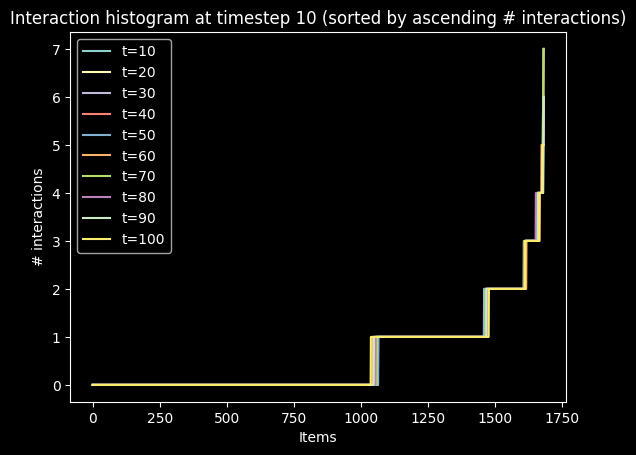

In [184]:
# for every 10 timesteps plot line in different color
for i in range(10, 101, 10):
    plt.plot(np.arange(recsys.num_items), sorted(measurements['interaction_histogram'][i]), label=f't={i}')

plt.legend()
plt.title("Interaction histogram at timestep %d (sorted by ascending # interactions)" % timestep)
plt.xlabel("Items")
plt.ylabel("# interactions")
plt.show()

In [186]:
pd.DataFrame(measurements)
#plot time series of mse over timesteps
# plt.plot(measurements['mse'])

,interaction_histogram,mse,interaction_spread,rec_similarity,timesteps
0,None,0.077926,NaN,NaN,0
1,"[2.0, 4.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...",0.077926,-940.0,0.004164,1
2,"[1.0, 2.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 3.0, ...",0.077926,0.5,0.004155,2
3,"[5.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0.077926,-0.5,0.004157,3
4,"[1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0.077926,-0.5,0.004206,4
...,...,...,...,...,...
96,"[0.0, 4.0, 0.0, 1.0, 2.0, 0.0, 4.0, 1.0, 2.0, ...",0.077926,0.0,0.004172,96
97,"[2.0, 0.0, 2.0, 1.0, 1.0, 0.0, 2.0, 1.0, 1.0, ...",0.077926,0.0,0.004226,97
98,"[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 3.0, ...",0.077926,0.0,0.004173,98
99,"[1.0, 1.0, 2.0, 3.0, 3.0, 1.0, 0.0, 1.0, 2.0, ...",0.077926,1.5,0.004217,99


In [61]:
# print majority / minority outcome stats
def majority_minority_outcomes(metric, split_index):
    split_indices = [split_index]

        
    maj_mean = metric.last_observation[:split_index].mean()
    maj_std = metric.last_observation[:split_index].std()

    min_mean = metric.last_observation[split_index:].mean()
    min_std = metric.last_observation[split_index:].std()

    print("Majority group statistics: ", maj_mean, "(mean), ", maj_std, "(std)")
    print("Minority group statistics: ", min_mean, "(mean), ", min_std, "(std)")
    print()
    
    metric.hist(split_indices)

In [ ]:
majority_minority_outcomes(mse, )